In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import datetime
import os

In [2]:
#Wind Power Production - Hourly Averaged Actual and Forecasted Values
url = 'http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13483&reportTitle=Solar%20Power%20Production%20-%20Hourly%20Averaged%20Actual%20and%20Forecasted%20Values&showHTMLView=&mimicKey'

In [3]:
response = requests.get(url)

In [4]:
soup = bs(response.text, 'html.parser')

In [5]:
title_results = soup.find_all('td', class_='labelOptional_ind')

In [6]:
url_results = soup.find_all('td', class_='labelOptional', text=True)

In [8]:
base_url = 'http://mis.ercot.com'

data_urls = []

for result in url_results:
    try:
        end_url = result.find('div').a['href']
        full_url = base_url + end_url
        data_urls.append(full_url)
        #print(full_url)
    except:
        pass

## Extract Zip File from URL

In [9]:
data = requests.get(data_urls[0], stream=True)

In [10]:
import requests, zipfile, io

z = zipfile.ZipFile(io.BytesIO(data.content))
z.extractall()
file = z.namelist()[0]

print(f'File Name: {file}')

File Name: cdr.00013483.0000000000000000.20200727.205513.PVGRHRLYAVGACTNP4737.csv


In [11]:
#load zip file to df
solar_fcst = pd.read_csv(file)

#delete zip file after reading
os.remove(file)

In [12]:
solar_fcst

,DELIVERY_DATE,HOUR_ENDING,ACTUAL_SYSTEM_WIDE,COP_HSL_SYSTEM_WIDE,STPPF_SYSTEM_WIDE,PVGRPP_SYSTEM_WIDE,DSTFlag
0,07/25/2020,21,109.20,144.5,194.0,164.9,N
1,07/25/2020,22,0.09,0.0,0.0,0.0,N
2,07/25/2020,23,0.09,0.0,0.0,0.0,N
3,07/25/2020,24,0.09,0.0,0.0,0.0,N
4,07/26/2020,1,0.09,0.0,0.0,0.0,N
...,...,...,...,...,...,...,...
211,08/03/2020,16,NaN,2852.5,3254.3,2600.4,N
212,08/03/2020,17,NaN,2744.4,3122.4,2386.6,N
213,08/03/2020,18,NaN,2561.8,2921.7,2128.5,N
214,08/03/2020,19,NaN,2123.7,2418.3,1798.1,N


In [13]:
#clean existing columns
solar_fcst['DELIVERY_DATE'] = pd.to_datetime(solar_fcst.DELIVERY_DATE).dt.normalize()

#add file name and process info to df
solar_fcst['FileName'] = z.namelist()[0]
solar_fcst['ProcessDate'] = pd.to_datetime(solar_fcst.FileName.str.split('.').str[3]).dt.normalize()
solar_fcst['ProcessHour'] = solar_fcst.FileName.str.split('.').str[4]
solar_fcst['ProcessDT'] = pd.to_datetime(solar_fcst.FileName.str.split('.').str[3] + solar_fcst.FileName.str.split('.').str[4])
solar_fcst['ProcessHour'] = solar_fcst.ProcessHour.str[0:2]

#change hour ending data type to string
solar_fcst.HOUR_ENDING = solar_fcst.HOUR_ENDING.astype(str)

#add delivery date time
solar_fcst['DeliveryDT'] = pd.to_datetime(solar_fcst.DELIVERY_DATE) + solar_fcst.HOUR_ENDING.astype('timedelta64[h]')

#add weekday columns
solar_fcst['Weekday'] = solar_fcst.DeliveryDT.dt.day_name().str.upper()

In [14]:
solar_fcst.head()

,DELIVERY_DATE,HOUR_ENDING,ACTUAL_SYSTEM_WIDE,COP_HSL_SYSTEM_WIDE,STPPF_SYSTEM_WIDE,PVGRPP_SYSTEM_WIDE,DSTFlag,FileName,ProcessDate,ProcessHour,ProcessDT,DeliveryDT,Weekday
0,2020-07-25,21,109.20,144.5,194.0,164.9,N,cdr.00013483.0000000000000000.20200727.205513....,2020-07-27,20,2020-07-27 20:55:13,2020-07-25 21:00:00,SATURDAY
1,2020-07-25,22,0.09,0.0,0.0,0.0,N,cdr.00013483.0000000000000000.20200727.205513....,2020-07-27,20,2020-07-27 20:55:13,2020-07-25 22:00:00,SATURDAY
2,2020-07-25,23,0.09,0.0,0.0,0.0,N,cdr.00013483.0000000000000000.20200727.205513....,2020-07-27,20,2020-07-27 20:55:13,2020-07-25 23:00:00,SATURDAY
3,2020-07-25,24,0.09,0.0,0.0,0.0,N,cdr.00013483.0000000000000000.20200727.205513....,2020-07-27,20,2020-07-27 20:55:13,2020-07-26 00:00:00,SUNDAY
4,2020-07-26,1,0.09,0.0,0.0,0.0,N,cdr.00013483.0000000000000000.20200727.205513....,2020-07-27,20,2020-07-27 20:55:13,2020-07-26 01:00:00,SUNDAY


In [16]:
solar_fcst.describe()

,ACTUAL_SYSTEM_WIDE,COP_HSL_SYSTEM_WIDE,STPPF_SYSTEM_WIDE,PVGRPP_SYSTEM_WIDE
count,48.000000,216.000000,216.000000,216.000000
mean,1469.560208,1400.835185,1447.037963,1181.419444
std,1495.253485,1490.899081,1527.967567,1264.611921
min,0.020000,0.000000,0.000000,0.000000
25%,0.090000,0.000000,0.000000,0.000000
50%,1025.515000,446.650000,474.300000,381.550000
75%,3020.207500,3075.075000,3159.600000,2541.575000
max,3636.160000,3744.300000,3744.300000,3412.900000


In [18]:
solar_fcst.dtypes

DELIVERY_DATE          datetime64[ns]
HOUR_ENDING                    object
ACTUAL_SYSTEM_WIDE            float64
COP_HSL_SYSTEM_WIDE           float64
STPPF_SYSTEM_WIDE             float64
PVGRPP_SYSTEM_WIDE            float64
DSTFlag                        object
FileName                       object
ProcessDate            datetime64[ns]
ProcessHour                    object
ProcessDT              datetime64[ns]
DeliveryDT             datetime64[ns]
Weekday                        object
dtype: object

### Convert DF to Long Format (i.e. Unpivot Forecast columns)

In [20]:
#use pd.melt to unpivot columns
long_solar_fcst = pd.melt(solar_fcst, id_vars=['DELIVERY_DATE', 'HOUR_ENDING', 'DSTFlag', 'FileName', 'ProcessDate', 'ProcessHour', 'ProcessDT', 'DeliveryDT', 'Weekday'],var_name='solar_zone', value_name ='mw')

#extract type and zone from WindZone column
long_solar_fcst['Type'] = long_solar_fcst.solar_zone.str.split('_').str[0]
long_solar_fcst['Zone'] = long_solar_fcst.solar_zone.str.split('_', n=1).str[1]


#rename columns
long_solar_fcst = long_solar_fcst.rename(columns = {'DeliveryDT':'delivery_dt', 'DELIVERY_DATE':'delivery_date', 'HOUR_ENDING':'delivery_hour', 
                                                  'DSTFlag':'dst_flag', 'Weekday':'weekday', 'Type':'type', 'Zone':'zone', 'MW':'mw', 
                                                  'ProcessDate':'process_date', 'ProcessHour':'process_hour', 'ProcessDT':'process_dt', 'FileName':'file_name'}, inplace=False)
#reorder columns
arranged_columns = ['delivery_dt', 'delivery_date', 'delivery_hour', 'dst_flag', 'weekday', 'type', 'zone', 'mw', 'process_date', 'process_hour',
                    'process_dt', 'file_name']

long_solar_fcst = long_solar_fcst[arranged_columns]

long_solar_fcst

,delivery_dt,delivery_date,delivery_hour,dst_flag,weekday,type,zone,mw,process_date,process_hour,process_dt,file_name
0,2020-07-25 21:00:00,2020-07-25,21,N,SATURDAY,ACTUAL,SYSTEM_WIDE,109.20,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
1,2020-07-25 22:00:00,2020-07-25,22,N,SATURDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
2,2020-07-25 23:00:00,2020-07-25,23,N,SATURDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
3,2020-07-26 00:00:00,2020-07-25,24,N,SUNDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
4,2020-07-26 01:00:00,2020-07-26,1,N,SUNDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
...,...,...,...,...,...,...,...,...,...,...,...,...
859,2020-08-03 16:00:00,2020-08-03,16,N,MONDAY,PVGRPP,SYSTEM_WIDE,2600.40,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
860,2020-08-03 17:00:00,2020-08-03,17,N,MONDAY,PVGRPP,SYSTEM_WIDE,2386.60,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
861,2020-08-03 18:00:00,2020-08-03,18,N,MONDAY,PVGRPP,SYSTEM_WIDE,2128.50,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
862,2020-08-03 19:00:00,2020-08-03,19,N,MONDAY,PVGRPP,SYSTEM_WIDE,1798.10,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....


In [27]:
long_solar_fcst.zone.unique()

array(['SYSTEM_WIDE', 'HSL_SYSTEM_WIDE'], dtype=object)

## Plotting Forecasts

In [21]:
import plotly.express as px

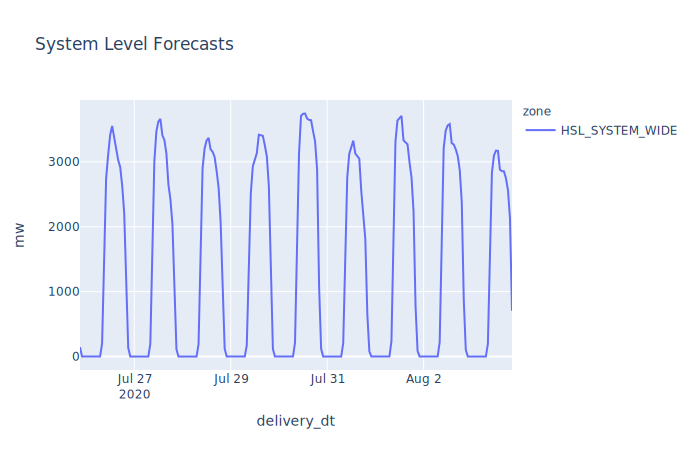

In [28]:
system_df = long_solar_fcst.loc[(long_solar_fcst.type == 'COP') & (long_solar_fcst.zone == 'HSL_SYSTEM_WIDE'), :] 

system_df.head()

systemFig = px.line(system_df, x="delivery_dt", y="mw", title='System Level Forecasts', color='zone')

systemFig.show('svg')

## Load Data to PostgreSQL Database

In [29]:
from sqlalchemy import create_engine

In [30]:
connection_string = f"postgres:trumpet5@localhost:5432/ercot_db"
engine = create_engine(f'postgresql://{connection_string}')

In [31]:
#fill table
long_solar_fcst.to_sql(name='da_solar_fcst', con=engine, if_exists='append', index=False)

In [32]:
#Print Table
pd.read_sql_query('select * from da_solar_fcst', con=engine)

,delivery_dt,delivery_date,delivery_hour,dst_flag,weekday,type,zone,mw,process_date,process_hour,process_dt,file_name
0,2020-07-25 21:00:00,2020-07-25,21,N,SATURDAY,ACTUAL,SYSTEM_WIDE,109.20,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
1,2020-07-25 22:00:00,2020-07-25,22,N,SATURDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
2,2020-07-25 23:00:00,2020-07-25,23,N,SATURDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
3,2020-07-26 00:00:00,2020-07-25,24,N,SUNDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
4,2020-07-26 01:00:00,2020-07-26,1,N,SUNDAY,ACTUAL,SYSTEM_WIDE,0.09,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
...,...,...,...,...,...,...,...,...,...,...,...,...
859,2020-08-03 16:00:00,2020-08-03,16,N,MONDAY,PVGRPP,SYSTEM_WIDE,2600.40,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
860,2020-08-03 17:00:00,2020-08-03,17,N,MONDAY,PVGRPP,SYSTEM_WIDE,2386.60,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
861,2020-08-03 18:00:00,2020-08-03,18,N,MONDAY,PVGRPP,SYSTEM_WIDE,2128.50,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
862,2020-08-03 19:00:00,2020-08-03,19,N,MONDAY,PVGRPP,SYSTEM_WIDE,1798.10,2020-07-27,20,2020-07-27 20:55:13,cdr.00013483.0000000000000000.20200727.205513....
